In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import lagrange
from ipywidgets import interact, IntSlider
from IPython.display import display

Fonction de résolution

In [3]:
def solve_2D_charge_step(H_prev, K, Ss, dt, dz, dx, alpha, bc_types, bc_values):
    """
    Calcule un pas de temps de l'équation de diffusion 2D avec des BC flexibles.
    bc_types: Tuple(str, str, str, str) -> (haut, bas, gauche, droite)
    bc_values: Tuple(float, float, float, float) -> valeurs associées
    """
    Nz, Nx = H_prev.shape
    N = Nz * Nx
    A = lil_matrix((N, N))
    b = np.zeros(N)
    coef_z, coef_x = K / dz**2, K / dx**2
    bc_top, bc_bottom, bc_left, bc_right = bc_types
    val_top, val_bottom, val_left, val_right = bc_values
    source_scaling_factor = dt / Ss

    for i in range(Nz):
        for j in range(Nx):
            k = i * Nx + j
            if i == 0:
                if bc_top == 'dirichlet': A[k, k], b[k] = 1.0, val_top
            elif i == Nz - 1:
                if bc_bottom == 'dirichlet': A[k, k], b[k] = 1.0, val_bottom
            elif j == 0:
                if bc_left == 'dirichlet': A[k, k], b[k] = 1.0, val_left
                elif bc_left == 'neumann':
                    A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                    A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                    A[k, k+1] = -2*(1-alpha)*coef_x
                    source_term = (2 * val_left / dx)
                    b[k] = ((Ss/dt-2*alpha*(coef_z+coef_x))*H_prev[i,j] + alpha*coef_z*(H_prev[i-1,j]+H_prev[i+1,j]) + (2*alpha*coef_x)*H_prev[i,j+1]) + source_term
            elif j == Nx - 1:
                if bc_right == 'dirichlet': A[k, k], b[k] = 1.0, val_right
                elif bc_right == 'neumann':
                    A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                    A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                    A[k, k-1] = -2*(1-alpha)*coef_x
                    source_term = (2 * val_right / dx)
                    b[k] = ((Ss/dt-2*alpha*(coef_z+coef_x))*H_prev[i,j] + alpha*coef_z*(H_prev[i-1,j]+H_prev[i+1,j]) + (2*alpha*coef_x)*H_prev[i,j-1]) + source_term
            else:
                A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                A[k, k-1], A[k, k+1] = -(1-alpha)*coef_x, -(1-alpha)*coef_x
                b[k] = ((Ss/dt - 2*alpha*(coef_z+coef_x))*H_prev[i,j] + (alpha*coef_z)*(H_prev[i+1,j]+H_prev[i-1,j]) + (alpha*coef_x)*(H_prev[i,j+1]+H_prev[i,j-1]))
    
    h_new_flat = spsolve(A.tocsr(), b)
    return h_new_flat.reshape((Nz, Nx))

In [4]:
# Remplacez votre fonction de température par celle-ci
def solve_2d_temperature_step(T_prev, grad_H_z, grad_H_x, K, Ss, n, lambda_s, rhos_cs, dt, dz, dx, alpha, bc_types, bc_values):
    Nz, Nx = T_prev.shape
    N = Nz * Nx
    A = lil_matrix((N, N))
    b = np.zeros(N)
    RHO_W, C_W, LAMBDA_W = 1000.0, 4185.0, 0.6
    rho_mc_m = n * RHO_W * C_W + (1 - n) * rhos_cs
    lambda_m = (n * (LAMBDA_W)**0.5 + (1 - n) * (lambda_s)**0.5)**2
    kappa_e = lambda_m / rho_mc_m
    alpha_e = (RHO_W * C_W * K) / rho_mc_m
    coef_diff_z, coef_diff_x = kappa_e / dz**2, kappa_e / dx**2
    coef_adv_z, coef_adv_x = alpha_e / (2 * dz), alpha_e / (2 * dx)
    bc_top, bc_bottom, bc_left, bc_right = bc_types
    val_top, val_bottom, val_left, val_right = bc_values
    
    # Le flux de chaleur n'est pas lié au stockage Ss, mais directement à la température
    source_scaling_factor_T = 1 / rho_mc_m

    for i in range(Nz):
        for j in range(Nx):
            k = i * Nx + j
            if i == 0:
                if bc_top == 'dirichlet': A[k, k], b[k] = 1.0, val_top
            elif i == Nz - 1:
                if bc_bottom == 'dirichlet': A[k, k], b[k] = 1.0, val_bottom
            elif j == 0:
                if bc_left == 'neumann':
                    A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                    A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+1]   = -2*(1-alpha)*coef_diff_x
                    # ====================== CORRECTION NEUMANN ======================
                    source_term = (2 * val_left / dx) * source_scaling_factor_T
                    b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                           (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                           (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                           (2*alpha*coef_diff_x)*T_prev[i,j+1] ) + source_term
                    # ===============================================================
            elif j == Nx - 1:
                if bc_right == 'neumann':
                    A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                    A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k-1]   = -2*(1-alpha)*coef_diff_x
                    # ====================== CORRECTION NEUMANN ======================
                    source_term = (2 * val_right / dx) * source_scaling_factor_T
                    b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                           (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                           (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                           (2*alpha*coef_diff_x)*T_prev[i,j-1] ) + source_term
                    # ===============================================================
            else:
                A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                A[k, k-1]   = -(1-alpha)*coef_diff_x - (1-alpha)*coef_adv_x*grad_H_x[i,j]
                A[k, k+1]   = -(1-alpha)*coef_diff_x + (1-alpha)*coef_adv_x*grad_H_x[i,j]
                b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                       (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                       (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                       (alpha*coef_diff_x + alpha*coef_adv_x*grad_H_x[i,j])*T_prev[i,j-1] + \
                       (alpha*coef_diff_x - alpha*coef_adv_x*grad_H_x[i,j])*T_prev[i,j+1] )

    T_new_flat = spsolve(A.tocsr(), b)
    return T_new_flat.reshape((Nz, Nx))

Paramètres du problème

In [5]:
# Géométrie
Nz, Nx = 101, 26
Lz, Lx = 0.4, 0.1
dz, dx = Lz / (Nz - 1), Lx / (Nx - 1)

# Physique (tiré de vos informations sauvegardées)
K = 1e-5
n = 0.1
Ss = n / Lz
lambda_s = 2
rhos_cs = 4e6

# Temps
total_time = 3600*24
dt = 300
n_steps = int(total_time / dt)
alpha = 0.5

Simulation de H

In [6]:
print("--- Début de la simulation pour H ---")
bc_types_H = ('dirichlet', 'dirichlet', 'neumann', 'neumann')
bc_values_H = (0.85, 0.0, 1e-5, -1e-5)
H_results = np.zeros((Nz, Nx, n_steps + 1))
H_profil_z = np.linspace(bc_values_H[0], bc_values_H[1], Nz)
H_results[:, :, 0] = np.tile(H_profil_z.reshape(-1, 1), (1, Nx))

for i in tqdm(range(n_steps), desc="Simulation H"):
    H_results[:, :, i+1] = solve_2D_charge_step(
        H_results[:, :, i], K, Ss, dt, dz, dx, alpha, bc_types_H, bc_values_H
    )
print("--- Simulation H terminée ---")

--- Début de la simulation pour H ---


Simulation H: 100%|██████████| 288/288 [00:13<00:00, 21.89it/s]

--- Simulation H terminée ---


Visulisation de la charge

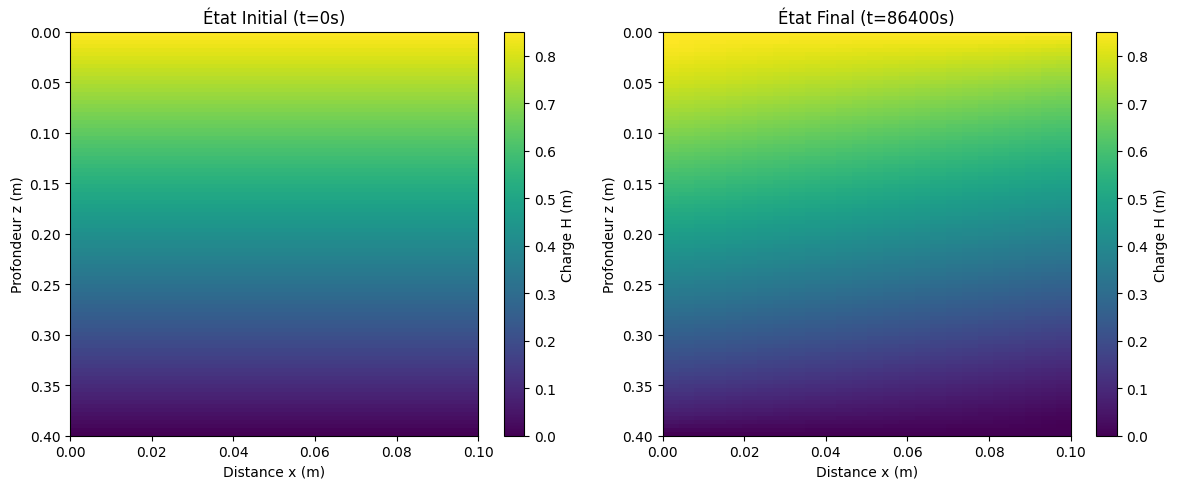

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# État initial
im0 = axes[0].imshow(H_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0].set_title("État Initial (t=0s)")
axes[0].set_xlabel("Distance x (m)"), axes[0].set_ylabel("Profondeur z (m)")
fig.colorbar(im0, ax=axes[0], label="Charge H (m)")
# État final
im1 = axes[1].imshow(H_results[:,:,-1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[1].set_title(f"État Final (t={total_time}s)")
axes[1].set_xlabel("Distance x (m)"), axes[1].set_ylabel("Profondeur z (m)")
fig.colorbar(im1, ax=axes[1], label="Charge H (m)")
plt.tight_layout()
plt.show()


Profil de température initial

Calcul de gradients de la charge

In [8]:
print("Calcul des gradients de H...")
grad_H_z_all_steps = np.zeros_like(H_results)
grad_H_x_all_steps = np.zeros_like(H_results)
for i in range(H_results.shape[2]):
    gradients = np.gradient(H_results[:, :, i], dz, dx)
    grad_H_z_all_steps[:, :, i] = gradients[0]
    grad_H_x_all_steps[:, :, i] = gradients[1]
print("Calcul des gradients terminé.")


Calcul des gradients de H...
Calcul des gradients terminé.


Simulation de la température

In [9]:
print("\n--- Début de la simulation pour T ---")
# Condition initiale pour T via interpolation
T_mesures = np.array([287.159, 287.248, 287.32, 287.272, 287.08]) - 273.15
z_mesures = np.linspace(0, Lz, len(T_mesures))
poly_lagrange = lagrange(z_mesures, T_mesures)
z_grid = np.linspace(0, Lz, Nz)
T_init_1D = poly_lagrange(z_grid)
T_init_2D = np.tile(T_init_1D.reshape(-1, 1), (1, Nx))

# Conditions aux limites pour T (Dirichlet haut/bas, Neumann côtés)
bc_types_T = ('dirichlet', 'dirichlet', 'neumann', 'neumann')
bc_values_T = (T_init_1D[0], T_init_1D[-1], 0, 0) # Températures basées sur l'IC, flux nul

# Initialisation et boucle
T_results = np.zeros((Nz, Nx, n_steps + 1))
T_results[:, :, 0] = T_init_2D
for i in tqdm(range(n_steps), desc="Simulation T"):
    T_results[:, :, i+1] = solve_2d_temperature_step(
        T_prev=T_results[:, :, i], 
        grad_H_z=grad_H_z_all_steps[:, :, i], 
        grad_H_x=grad_H_x_all_steps[:, :, i],
        K=K, Ss=Ss, n=n, lambda_s=lambda_s, rhos_cs=rhos_cs,
        dt=dt, dz=dz, dx=dx, alpha=alpha,
        bc_types=bc_types_T, bc_values=bc_values_T
    )
print("--- Simulation T terminée ---")


--- Début de la simulation pour T ---


Simulation T: 100%|██████████| 288/288 [00:17<00:00, 16.77it/s]

--- Simulation T terminée ---


Affichage des résultats

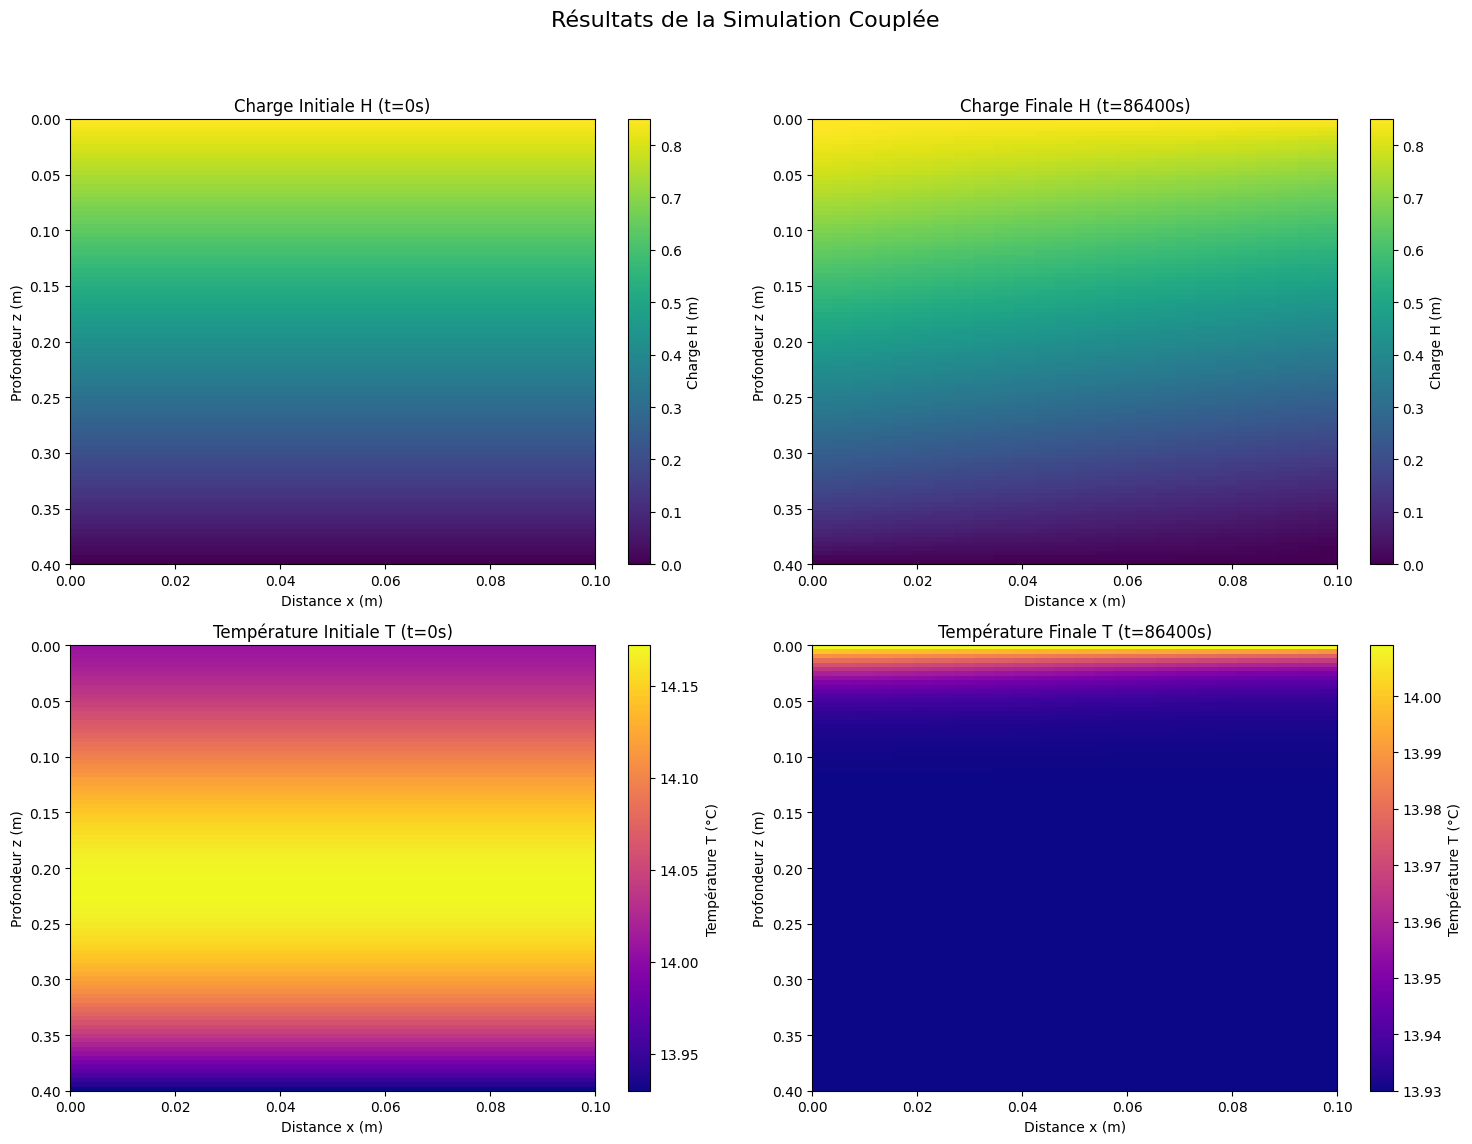

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Résultats de la Simulation Couplée', fontsize=16)

# -- Affichage de H --
im0 = axes[0, 0].imshow(H_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 0].set_title("Charge Initiale H (t=0s)")
fig.colorbar(im0, ax=axes[0, 0], label="Charge H (m)")

im1 = axes[0, 1].imshow(H_results[:, :, -1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 1].set_title(f"Charge Finale H (t={total_time}s)")
fig.colorbar(im1, ax=axes[0, 1], label="Charge H (m)")

# -- Affichage de T --
im2 = axes[1, 0].imshow(T_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 0].set_title("Température Initiale T (t=0s)")
fig.colorbar(im2, ax=axes[1, 0], label="Température T (°C)")

im3 = axes[1, 1].imshow(T_results[:, :, -1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 1].set_title(f"Température Finale T (t={total_time}s)")
fig.colorbar(im3, ax=axes[1, 1], label="Température T (°C)")

for ax in axes.flat:
    ax.set_xlabel("Distance x (m)")
    ax.set_ylabel("Profondeur z (m)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
idx_final = -1

# Si les lignes de niveau sont horizontales (comme dans votre image), 
# le gradient vertical (dH/dz) doit être bien plus grand que le gradient horizontal (dH/dx).
grad_z_mean = np.mean(np.abs(grad_H_z_all_steps[:, :, idx_final]))
grad_x_mean = np.mean(np.abs(grad_H_x_all_steps[:, :, idx_final]))

print(f"Moyenne |dH/dz| (vertical): {grad_z_mean:.4e}")
print(f"Moyenne |dH/dx| (horizontal): {grad_x_mean:.4e}")

# Puisque les lignes de niveau sont presque horizontales,
# ATTENDU : grad_z_mean doit être nettement supérieur à grad_x_mean.
# Si vous obtenez l'inverse, vos composantes x et z sont interverties.

Moyenne |dH/dz| (vertical): 2.1250e+00
Moyenne |dH/dx| (horizontal): 8.2074e-01


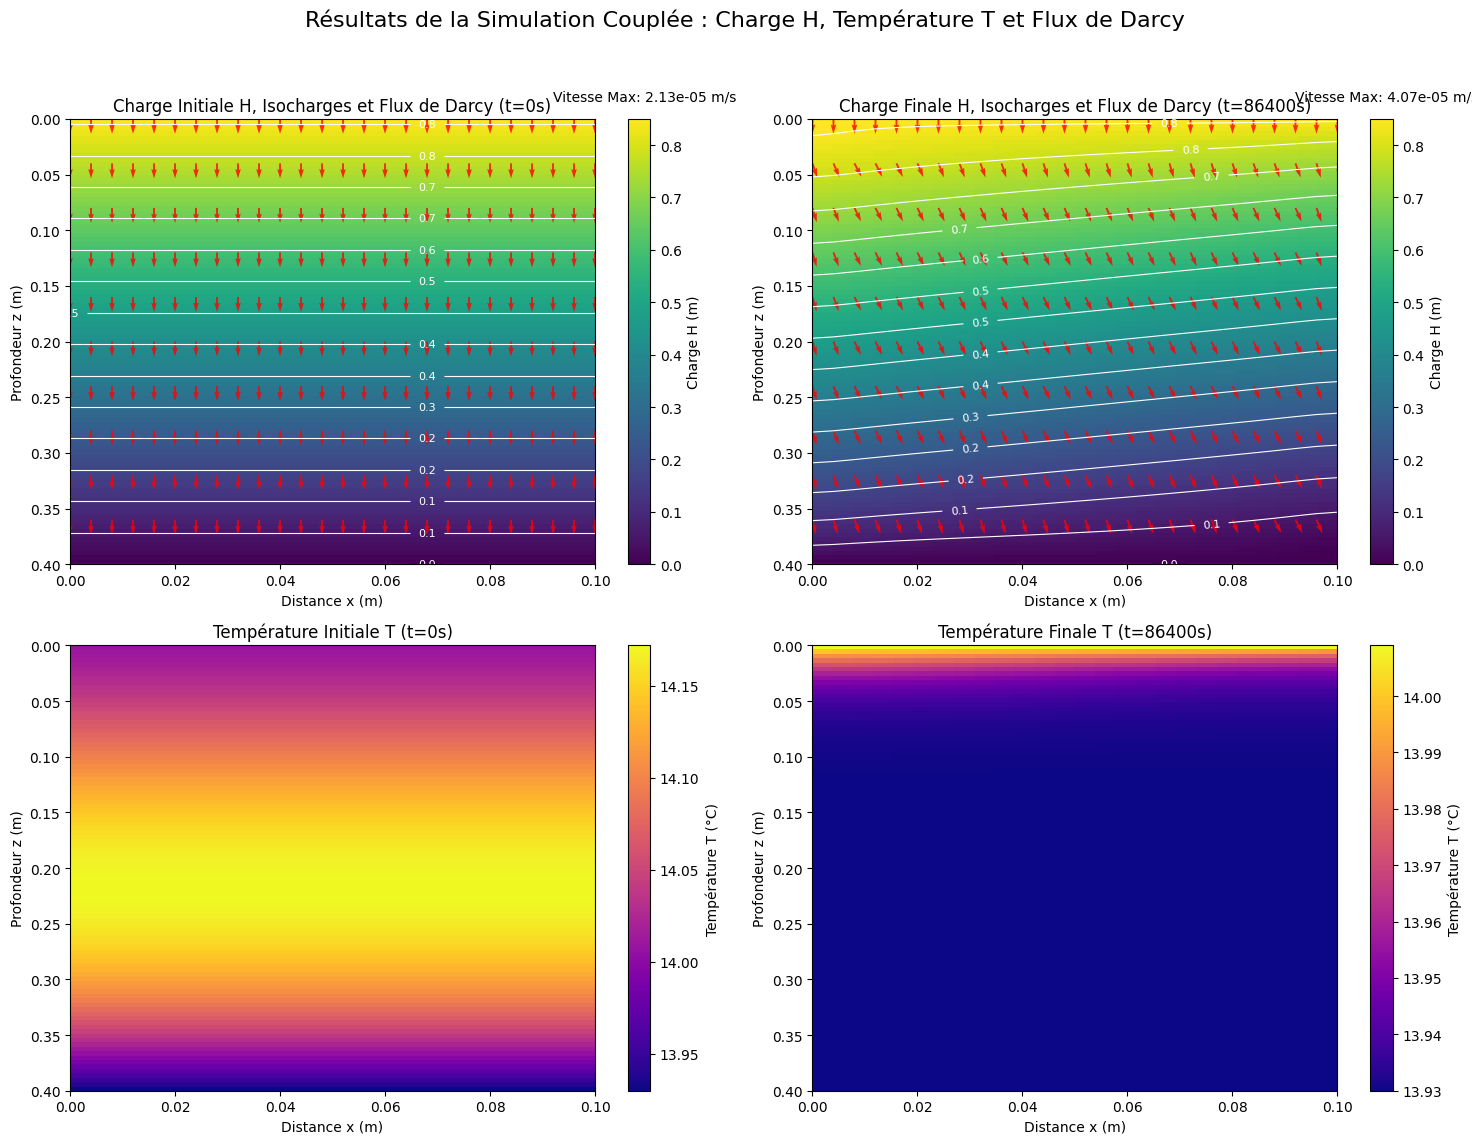

In [12]:
# --- 1. PRÉPARATION DES DONNÉES DE VITESSE (Inchagé) ---

# Récupération des dimensions (assurez-vous que Nx et Nz sont corrects)
Nz, Nx, Nt = H_results.shape 

# Calcul des coordonnées réelles pour le tracé (nécessaire pour quiver)
Z_plot, X_plot = np.mgrid[0:Lz:(Nz*1j), 0:Lx:(Nx*1j)]

# Les indices 0 (Initial) et -1 (Final)
idx_initial = 0
idx_final = -1

# Vitesse Initiale (v = -K * grad(H))
vx0 = -K * grad_H_x_all_steps[:, :, idx_initial]
vz0 = K * grad_H_z_all_steps[:, :, idx_initial]
mag0 = np.sqrt(vx0**2 + vz0**2)

# Vitesse Finale (v = -K * grad(H))
vxf = -K * grad_H_x_all_steps[:, :, idx_final]
vzf = K * grad_H_z_all_steps[:, :, idx_final]
magf = np.sqrt(vxf**2 + vzf**2)

# Normalisation des vecteurs pour l'affichage (évite les tracés vides)
epsilon = 1e-12 
mag0_safe = np.where(mag0 == 0, epsilon, mag0)
vx_norm0 = vx0 / mag0_safe
vz_norm0 = vz0 / mag0_safe
magf_safe = np.where(magf == 0, epsilon, magf)
vx_normf = vxf / magf_safe
vz_normf = vzf / magf_safe


# --------------------------------------------------------------------------
# --- 2. BLOC DE TRACÉ MODIFIÉ ---

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Résultats de la Simulation Couplée : Charge H, Température T et Flux de Darcy', fontsize=16)

# MODIFICATION CLÉ POUR UNE GRILLE ASYMÉTRIQUE
# skip_z : Saut vertical (lignes). Garder plus grand pour éviter la saturation verticale.
skip_z = 10 
# skip_x : Saut horizontal (colonnes). Réduire à 1 ou 2 pour plus de flèches en x.
skip_x = 1 

# Définition du paramètre de sous-échantillonnage pour l'indexation
# Le premier indice est pour les lignes (Z), le second pour les colonnes (X)
skip_indices = (slice(None, None, skip_z), slice(None, None, skip_x))

# Scale pour la taille des flèches normalisées (à ajuster visuellement)
quiver_scale = 35 

# --- A. CHARGE INITIALE H (t=0s) ---
im0 = axes[0, 0].imshow(H_results[:, :, idx_initial], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 0].set_title("Charge Initiale H, Isocharges et Flux de Darcy (t=0s)")
fig.colorbar(im0, ax=axes[0, 0], label="Charge H (m)")

# AJOUT DES LIGNES DE NIVEAU (CONTOUR) pour la charge H
# Utilisez axes.contour(X_plot, Z_plot, H_data, N_levels, ...)
# Note : H_results doit être passé tel quel, sans inversion (imshow gère l'inversion de l'axe Y)
H0_data = H_results[:, :, idx_initial]
contours0 = axes[0, 0].contour(
    X_plot, Z_plot, H0_data, 
    levels=15, # Nombre de lignes de niveau à tracer (à ajuster)
    colors='white', 
    linewidths=0.8,
    linestyles='solid'
)
# Ajout des étiquettes des lignes de niveau
axes[0, 0].clabel(contours0, inline=True, fontsize=8, fmt='%1.1f')


# Tracé du champ de vitesse normalisé
axes[0, 0].quiver(
    X_plot[skip_indices], Z_plot[skip_indices], 
    vx_norm0[skip_indices], vz_norm0[skip_indices],
    color='red', 
    scale=quiver_scale, 
    alpha=0.8,
)
# Ajout d'une clé d'échelle pour la magnitude réelle (Code inchangé)
axes[0, 0].quiverkey(
    Q=axes[0, 0].quiver(
        0, 0,                                 
        np.max(mag0), 0,                      
        scale=np.max(mag0) * 0.5,             
        alpha=0                               
    ),
    X=0.9, Y=1.05, U=np.max(mag0),            
    label=f'Vitesse Max: {np.max(mag0):.2e} m/s', 
    labelpos='E'
)

# --- B. CHARGE FINALE H (t=total_time) ---
im1 = axes[0, 1].imshow(H_results[:, :, idx_final], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 1].set_title(f"Charge Finale H, Isocharges et Flux de Darcy (t={total_time}s)")
fig.colorbar(im1, ax=axes[0, 1], label="Charge H (m)")

# AJOUT DES LIGNES DE NIVEAU (CONTOUR) pour la charge H
Hf_data = H_results[:, :, idx_final]
contoursf = axes[0, 1].contour(
    X_plot, Z_plot, Hf_data, 
    levels=15, # Nombre de lignes de niveau à tracer (à ajuster)
    colors='white', 
    linewidths=0.8,
    linestyles='solid'
)
# Ajout des étiquettes des lignes de niveau
axes[0, 1].clabel(contoursf, inline=True, fontsize=8, fmt='%1.1f')


# Tracé du champ de vitesse normalisé
axes[0, 1].quiver(
    X_plot[skip_indices], Z_plot[skip_indices], 
    vx_normf[skip_indices], vz_normf[skip_indices],
    color='red', 
    scale=quiver_scale, 
    alpha=0.8
)
# Ajout d'une clé d'échelle pour la magnitude réelle (Code inchangé)
axes[0, 1].quiverkey(
    Q=axes[0, 1].quiver(
        0, 0, 
        np.max(magf), 0,
        scale=np.max(magf) * 0.5,
        alpha=0
    ), 
    X=0.9, Y=1.05, U=np.max(magf), 
    label=f'Vitesse Max: {np.max(magf):.2e} m/s', 
    labelpos='E'
)

# --- Affichage de T (inchangé) ---
im2 = axes[1, 0].imshow(T_results[:, :, idx_initial], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 0].set_title("Température Initiale T (t=0s)")
fig.colorbar(im2, ax=axes[1, 0], label="Température T (°C)")

im3 = axes[1, 1].imshow(T_results[:, :, idx_final], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 1].set_title(f"Température Finale T (t={total_time}s)")
fig.colorbar(im3, ax=axes[1, 1], label="Température T (°C)")

for ax in axes.flat:
    ax.set_xlabel("Distance x (m)")
    ax.set_ylabel("Profondeur z (m)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output

# --- 0. Paramètres et Préparation (Lecture des variables globales) ---
# NOTE: Ces variables sont lues de la mémoire du kernel 
Nz, Nx, Nt = H_results.shape 
total_time = 3600 * 24
dt = 300
Lz, Lx = 0.4, 0.1
K = 1e-5
n_steps = int(total_time / dt)

# Grilles et indices pour le tracé
Z_plot, X_plot = np.mgrid[0:Lz:(Nz*1j), 0:Lx:(Nx*1j)]
skip_z = 10 
skip_x = 1 
skip_indices = (slice(None, None, skip_z), slice(None, None, skip_x))
quiver_scale = 35 
epsilon = 1e-12 

# Échelles de couleur (déterminées sur l'ensemble du temps pour la cohérence)
H_min, H_max = np.min(H_results), np.max(H_results)
T_min, T_max = np.min(T_results), np.max(T_results)
min_level_H = np.linspace(H_min, H_max, 20)
min_level_T = np.linspace(T_min, T_max, 20)


# --- 1. FONCTION DE TRACÉ DYNAMIQUE (Méthode Robuste) ---

def plot_dynamic_results(idx):
    
    current_time = idx * dt
    
    H_data = H_results[:, :, idx]
    T_data = T_results[:, :, idx]
    
    # Calcul de la vitesse (Flux de Darcy)
    vx = -K * grad_H_x_all_steps[:, :, idx]
    vz = K * grad_H_z_all_steps[:, :, idx]
    mag = np.sqrt(vx**2 + vz**2)
    mag_max = np.max(mag)
    
    # Normalisation des flèches pour l'affichage Quiver
    mag_safe = np.where(mag == 0, epsilon, mag)
    vx_norm = vx / mag_safe
    vz_norm = vz / mag_safe
    
    
    # --- Démarrage du tracé (Recréation de la figure) ---
    # Utilisation de clear_output pour rafraîchir le graphique si le mode 'widget' n'est pas utilisé
    # clear_output(wait=True) 
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Résultats de la Simulation Couplée : Temps = {current_time}s', fontsize=16)

    
    # --- A. CHARGE INITIALE H (t=0s) --- (Statique)
    ax0 = axes[0, 0]
    im0 = ax0.imshow(H_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis', vmin=H_min, vmax=H_max)
    ax0.set_title("Charge Initiale H, Isocharges et Flux de Darcy (t=0s)")
    fig.colorbar(im0, ax=ax0, label="Charge H (m)")
    contours0 = ax0.contour(X_plot, Z_plot, H_results[:, :, 0], levels=min_level_H[::3], colors='white', linewidths=0.8, linestyles='solid')
    ax0.clabel(contours0, inline=True, fontsize=8, fmt='%1.2f')
    
    vx0 = -K * grad_H_x_all_steps[:, :, 0]
    vz0 = K * grad_H_z_all_steps[:, :, 0]
    mag0 = np.sqrt(vx0**2 + vz0**2)
    mag0_safe = np.where(mag0 == 0, epsilon, mag0)
    quiv0 = ax0.quiver(X_plot[skip_indices], Z_plot[skip_indices], vx0[skip_indices]/mag0_safe[skip_indices], vz0[skip_indices]/mag0_safe[skip_indices], color='red', scale=quiver_scale, alpha=0.8)
    ax0.quiverkey(Q=quiv0, X=0.9, Y=1.05, U=np.max(mag0), label=f'Vitesse Max: {np.max(mag0):.2e} m/s', labelpos='E')


    # --- B. CHARGE H (Dynamique) ---
    ax1 = axes[0, 1]
    im1 = ax1.imshow(H_data, extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis', vmin=H_min, vmax=H_max)
    ax1.set_title(f"Charge H, Isocharges et Flux de Darcy (t={current_time}s)")
    fig.colorbar(im1, ax=ax1, label="Charge H (m)")
    
    # Contours Dynamiques
    contours1 = ax1.contour(X_plot, Z_plot, H_data, levels=min_level_H[::3], colors='white', linewidths=0.8, linestyles='solid')
    ax1.clabel(contours1, inline=True, fontsize=8, fmt='%1.2f')

    # Quiver Dynamique
    quiv1 = ax1.quiver(X_plot[skip_indices], Z_plot[skip_indices], vx_norm[skip_indices], vz_norm[skip_indices], color='red', scale=quiver_scale, alpha=0.8)
    
    mag_global_max = np.max(np.sqrt((-K * grad_H_x_all_steps)**2 + (K * grad_H_z_all_steps)**2))
    ax1.quiverkey(Q=quiv1, X=0.9, Y=1.05, U=mag_global_max, label=f'Vitesse Max (Global): {mag_global_max:.2e} m/s', labelpos='E')

    
    # --- C. TEMPÉRATURE INITIALE T (Statique) ---
    ax2 = axes[1, 0]
    im2 = ax2.imshow(T_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma', vmin=T_min, vmax=T_max)
    ax2.set_title("Température Initiale T (t=0s)")
    fig.colorbar(im2, ax=ax2, label="Température T (°C)")

    # --- D. TEMPÉRATURE T (Dynamique) ---
    ax3 = axes[1, 1]
    im3 = ax3.imshow(T_data, extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma', vmin=T_min, vmax=T_max)
    ax3.set_title(f"Température T (t={current_time}s)")
    fig.colorbar(im3, ax=ax3, label="Température T (°C)")

    # Mise en forme finale
    for ax in axes.flat:
        ax.set_xlabel("Distance x (m)")
        ax.set_ylabel("Profondeur z (m)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show(fig) # Afficher la figure mise à jour
    plt.close(fig) # Fermer la référence pour ne pas encombrer la mémoire


# --- 2. DÉMARRAGE DU WIDGET INTERACTIF ---

# Configuration du Slider
time_slider = IntSlider(
    min=0,
    max=n_steps, 
    step=1, 
    value=n_steps, 
    description='Index Temporel:',
    continuous_update=False 
)

# Liez la fonction de tracé dynamique (plot_dynamic_results) à l'index du slider (idx)
# L'utilisation de 'idx' comme argument de la fonction plot_dynamic_results
# est implicitement gérée par 'interact'
interact(plot_dynamic_results, idx=time_slider)

interactive(children=(IntSlider(value=288, continuous_update=False, description='Index Temporel:', max=288), O…

<function __main__.plot_dynamic_results(idx)>